<a href="https://colab.research.google.com/github/nilu-ai/Restaurant_Fttx_project/blob/main/Fttx_Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os
from ipywidgets import widgets

def create_folder_if_not_exists(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

def take_photo(id, quality=0.8):
    folder_name = str(id)
    create_folder_if_not_exists(folder_name)

    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      const cancel = document.createElement('button');
      cancel.textContent = 'Cancel';
      div.appendChild(capture);
      div.appendChild(cancel);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      let stop = false;
      const images = [];

      // Capture images until cancel is clicked.
      while (!stop) {
        await new Promise((resolve) => {
          capture.onclick = () => {
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const imageData = canvas.toDataURL('image/jpeg', quality);
            images.push(imageData);
            resolve();
          };
          cancel.onclick = () => {
            stop = true;
            resolve();
          };
        });
      }

      stream.getVideoTracks()[0].stop();
      div.remove();
      return images;
    }
    ''')

    display(js)
    images = eval_js('takePhoto({})'.format(quality))

    filenames = []
    for i, image_data in enumerate(images):
        binary = b64decode(image_data.split(',')[1])
        filename = os.path.join(folder_name, 'photo{}.jpg'.format(i))
        filenames.append(filename)
        with open(filename, 'wb') as f:
            f.write(binary)

    return filenames

id_widget = widgets.Text(description="Enter ID:")
display(id_widget)

def on_button_clicked(b):
    try:
        id = id_widget.value
        filenames = take_photo(id)
        print('Saved to:')
        for filename in filenames:
            print(filename)
    except Exception as err:
        print(str(err))

button = widgets.Button(description="Capture")
button.on_click(on_button_clicked)
display(button)


Text(value='', description='Enter ID:')

Button(description='Capture', style=ButtonStyle())

<IPython.core.display.Javascript object>

Saved to:
gasda/photo0.jpg
gasda/photo1.jpg
gasda/photo2.jpg
gasda/photo3.jpg
gasda/photo4.jpg
gasda/photo5.jpg
gasda/photo6.jpg
gasda/photo7.jpg
gasda/photo8.jpg
gasda/photo9.jpg
gasda/photo10.jpg
gasda/photo11.jpg
gasda/photo12.jpg
gasda/photo13.jpg
gasda/photo14.jpg
gasda/photo15.jpg


In [61]:
from google.colab import output
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# JavaScript to take a photo using the webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            document.body.appendChild(div);

            // Create the media stream
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            div.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            // Wait for capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            // Take the photo.
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            div.remove();
            return dataUrl;
        }
        takePhoto({quality: %f});
    ''' % quality)
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename



In [4]:
!unzip /content/Train.zip

Archive:  /content/Train.zip
   creating: Train/Abhishek 1/
  inflating: Train/Abhishek 1/WIN_20240524_15_28_24_Pro (2).jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_24_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_25_Pro (2).jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_25_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_37_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_39_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_41_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_42_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_44_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_45_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_47_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_48_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_50_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_28_52_Pro.jpg  
  inflating: Train/Abhishek 1/WIN_20240524_15_29_22_Pro.jpg  
  

Images Ko Train Kia he Yaha Se

In [25]:
import cv2
import os
import numpy as np

# Function to load images and labels from a dataset directory
def load_images(dataset_path):
    images = []
    labels = []
    label_id = 0
    label_dict = {}

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith("jpg") or file.endswith("png"):
                img_path = os.path.join(root, file)
                label = os.path.basename(root).replace(" ", "-").lower()  # Extract label from directory name

                # Assign a unique ID to each label
                if label not in label_dict:
                    label_dict[label] = label_id
                    label_id += 1

                # Load image and convert to grayscale

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                #cv_imshow(img)
                if img is not None:
                    images.append(img)
                    labels.append(label_dict[label])

    return images, np.array(labels), label_dict

# Function to train a face recognition model
def train_recognizer(images, labels):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    recognizer.train(images, labels)
    return recognizer

# Load images and labels from the dataset folder
dataset_path = "Train"
images, labels, label_dict = load_images(dataset_path)

# Train the recognizer
recognizer = train_recognizer(images, labels)

# Save the trained model to a file
model_filename = 'trained_model.yml'
recognizer.save(model_filename)
print(f"Model saved to {model_filename}")

# Save the label dictionary
label_dict_filename = 'label_dict.npy'
np.save(label_dict_filename, label_dict)
print(f"Label dictionary saved to {label_dict_filename}")

Model saved to trained_model.yml
Label dictionary saved to label_dict.npy



**MOdel Building With Some Optimization** *italicized text*

In [31]:
import cv2
import os
import numpy as np


recognizer = cv2.face.LBPHFaceRecognizer_create()

# Function to detect and extract faces from an image
def detect_and_extract_faces(image, face_cascade):
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    face_images = []
    for (x, y, w, h) in faces:
        face_img = image[y:y+h, x:x+w]
        face_images.append(face_img)
    return face_images

# Function to load images and labels from a dataset directory
def load_images(dataset_path, face_cascade_path):
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    images = []
    labels = []
    label_id = 0
    label_dict = {}

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith("jpg") or file.endswith("png"):
                img_path = os.path.join(root, file)
                label = os.path.basename(root).replace(" ", "-").lower()  # Extract label from directory name

                # Assign a unique ID to each label
                if label not in label_dict:
                    label_dict[label] = label_id
                    label_id += 1

                # Load image and convert to grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect and extract faces from the image
                    face_images = detect_and_extract_faces(img, face_cascade)
                    cv2_imshow(face_images)
                    for face_img in face_images:
                        images.append(face_img)
                        labels.append(label_dict[label])

    return images, np.array(labels), label_dict

# Function to train a face recognition model
def train_recognizer(images, labels):
    recognizer.train(images, labels)
    return recognizer

# Path to the Haar Cascade for face detection
face_cascade_path = '/content/haarcascade_frontalface_default.xml'

# Load images and labels from the dataset folder
dataset_path = "Train"
images, labels, label_dict = load_images(dataset_path, face_cascade_path)

# Train the recognizer
recognizer = train_recognizer(images, labels)

# Save the trained model to a file
model_filename = 'trained_model.yml'
recognizer.save(model_filename)
print(f"Model saved to {model_filename}")

# Save the label dictionary
label_dict_filename = 'label_dict.npy'
np.save(label_dict_filename, label_dict)
print(f"Label dictionary saved to {label_dict_filename}")


Model saved to trained_model.yml
Label dictionary saved to label_dict.npy


Prediction *Wala*

<IPython.core.display.Javascript object>

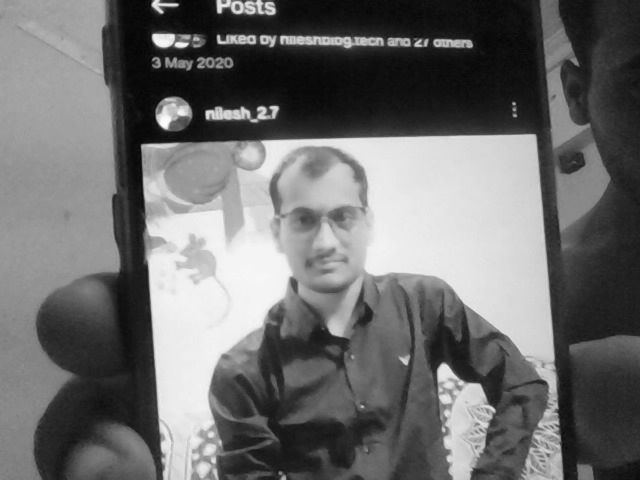

Predicted label: Unknown, Confidence: 97.33353389240654


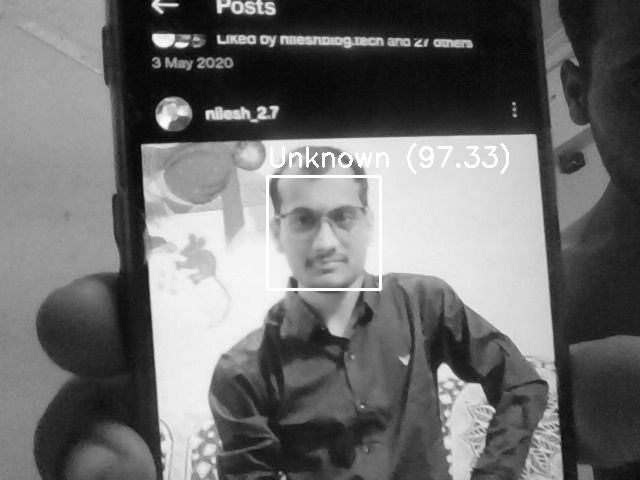

In [63]:
from google.colab.patches import cv2_imshow

face_cascade_path = '/content/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

#image me se Face Nikal Lena
def detect_and_extract_faces(image, face_cascade):
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    face_images = []
    for (x, y, w, h) in faces:
        face_img = image[y:y+h, x:x+w]
        face_images.append((face_img, (x, y, w, h)))
    return face_images

# Function to predict the identity of a new image
def predict_image(img_path):
    # Load the image and convert to grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    cv2_imshow(img)

    # Detect and extract faces from the image
    face_images = detect_and_extract_faces(img, face_cascade)

    if not face_images:
        print("No face detected in the image.")
        return

    for face_img, (x, y, w, h) in face_images:
        # Normlization and Resiszing Techniques
        face_img = cv2.resize(face_img, (128, 128))


        face_img = face_img / 255.0


        face_img = np.expand_dims(face_img, axis=-1)
        #model Ko Processs Image Send Kia he
        prediction, confidence = recognizer.predict(face_img)

        if confidence > 60:
            predicted_label = 'Unknown'
        else:
            predicted_label = next((label for label, idx in label_dict.items() if idx == prediction), 'Unknown')
        print(f"Predicted label: {predicted_label}, Confidence: {confidence}")

        # yahape Hamne Image pe Upar ek Text Add Kia He
        cv2.putText(img, f"{predicted_label} ({confidence:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

new_img_path=take_photo()
#new_img_path = '/content/salman.jfif'
predict_image(new_img_path)

<IPython.core.display.Javascript object>

Image saved to photo.jpg


In [59]:
!rm -rf "/content/gasda"